# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.15:34943")
client

Client Scheduler: tcp://10.32.16.15:34943 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_theta.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_rhodts.zarr')) #typo in filename - should be 'drhodts'
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    conv_horiz_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_TH_truth   (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhods                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhodt                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [7]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [8]:
pref=2000

### Checking if `rhs` and `lhs` seem to match

In [9]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [10]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

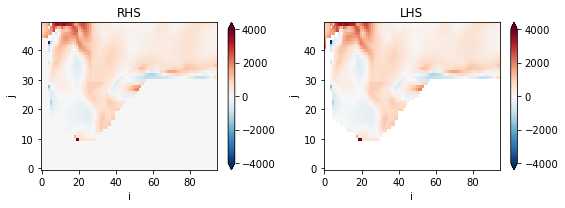

In [11]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} Combined\ terms\ for\ sigma\ ds \end{equation*} </font>

In [12]:
conv_horiz_adv_flux_SIG = ds_sig_theta.conv_horiz_adv_flux_TH + ds_sig_salt.conv_horiz_adv_flux_SLT
conv_horiz_diff_flux_SIG = ds_sig_theta.conv_horiz_diff_flux_TH + ds_sig_salt.conv_horiz_diff_flux_SLT
conv_vert_adv_flux_SIG = ds_sig_theta.conv_vert_adv_flux_TH + ds_sig_salt.conv_vert_adv_flux_SLT
conv_vert_diff_flux_SIG = ds_sig_theta.conv_vert_diff_flux_TH + ds_sig_salt.conv_vert_diff_flux_SLT
surface_flux_conv_SIG = ds_sig_theta.surface_flux_conv_TH + ds_sig_salt.surface_flux_SLT
sw_flux_salt_plume = ds_sig_theta.sw_flux_conv_TH + ds_sig_salt.salt_plume

In [13]:
ds_sig_flux_tems = xr.merge([conv_horiz_adv_flux_SIG.rename('conv_horiz_adv_flux_SIG'),
                             conv_horiz_diff_flux_SIG.rename('conv_horiz_diff_flux_SIG'),
                             conv_vert_adv_flux_SIG.rename('conv_vert_adv_flux_SIG'),
                             conv_vert_diff_flux_SIG.rename('conv_vert_diff_flux_SIG'),
                             surface_flux_conv_SIG.rename('surface_flux_conv_SIG'),
                             sw_flux_salt_plume.rename('sw_flux_salt_plume')])

In [14]:
ds_sig = xr.merge([ds_sig_flux_tems, ds_vel, ds_drhodts])
ds_sig

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    conv_horiz_adv_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SIG  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SIG    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SIG   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_SIG     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_salt_plume        (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    drhods                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>
    drhodt                    (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>

In [15]:
sigma2_snp = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT_snp, ds_tns.THETA_snp, pref,
                            output_dtypes=[ds_tns.SALT_snp.dtype],
                            dask='parallelized').reset_coords(drop=True).load()
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

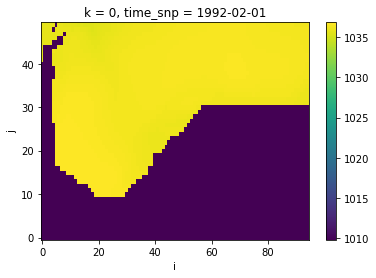

In [16]:
sigma2_snp[0,0].plot()

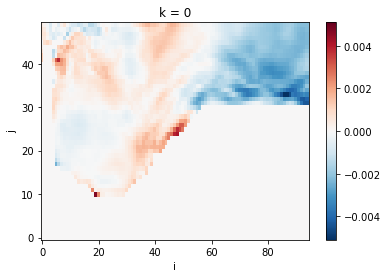

In [23]:
(sigma2.mean(dim='time')[0] - sigma2_snp.mean(dim='time_snp')[0]).plot()

In [ ]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[salt_bins],
                       weights=vol, dim=['i', 'j', 'k'])

In [ ]:
delta_theta = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)
total_time = (ds.time_snp[-1] - ds.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_theta * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False)
ds.total_tendency_TH_truth.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>